In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

In [2]:
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score):
    return (score/4104996.104768301) * 100

def rmse(preds, dtrain):
    labels = dtrain.get_label()
    return 'rmse', evaluation_metric(labels, preds), True

def rmse_xgboost(preds, dtrain):
    labels = dtrain.get_label()
    return 'rmse', evaluation_metric(labels, preds)

In [3]:
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col = 'DateTime')

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop(columns=["Day", "Year", "t2m", "power"])
all_data['num_missing'] = (all_data == -1).sum(axis=1)

cat_features = ['CloudForm', 'GroundState(code)', 'PhenomenonNumber']
all_data[cat_features] = all_data[cat_features].astype(str)
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

all_data_numeric = all_data.drop(columns=cat_features)
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_numeric),
                               encoded_cat_matrix],
                              format = 'csr')
num_train = len(train)
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]
y = train['power'].values
y_test = test['power'].values

# LightGBM

In [4]:
lgb_params = {'num_leaves': 17,
             'colsample_bytree': 0.7091234824890884,
             'reg_alpha': 0.7394476479071033,
             'reg_lambda': 7.808480534304585,
             'max_depth': 15,
             'learning_rate': 0.007814528175792283,
             'n_estimators': 2157,
             'min_child_samples': 11,
             'subsample': 0.7249013772087863}

In [6]:
lgb_oof_val_preds = np.zeros(X.shape[0])
lgb_oof_test_preds = np.zeros(X_test.shape[0])

folds = TimeSeriesSplit(n_splits=5)

for train_idx, valid_idx in folds.split(X, y) : 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    lgb_model = LGBMRegressor(**lgb_params) #lgb.
    lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              callbacks = [lgb.early_stopping(stopping_rounds = 300, verbose = 0)])
    
    lgb_oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    lgb_oof_val_preds[valid_idx] += lgb_model.predict(X_valid)

    lgb_score = evaluation_metric(y_valid, lgb_oof_val_preds[valid_idx])
    print(f"new fold RMSE: {lgb_score:.4f}")

    lgb_nrmse_score = nrmse(y_valid, lgb_oof_val_preds[valid_idx])
    print(f"new Normalized Validation RMSE: {lgb_nrmse_score:.4f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 5791, number of used features: 46
[LightGBM] [Info] Start training from score 4221853.220515
new fold RMSE: 759473.7603
new Normalized Validation RMSE: 0.0641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 11581, number of used features: 50
[LightGBM] [Info] Start training from score 4082546.515845
new fold RMSE: 754003.4425
new Normalized Validation RMSE: 0.0629
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 secon

In [7]:
# RMSE로 평가
lgb_score = evaluation_metric(y_test, lgb_oof_test_preds)
print(f"test RMSE: {lgb_score:.4f}")
print(f"test error percentage : {test_error_percentage(lgb_score):.4f}")

lgb_nrmse_score = nrmse(y_test, lgb_oof_test_preds)
print(f"Normalized test RMSE: {lgb_nrmse_score:.4f}")

test RMSE: 931521.0182
test error percentage : 22.6924
Normalized test RMSE: 0.0767


# XGBoost

In [9]:
xgb_params = {'eta': 0.9957304355968829, 
              'colsample_bynode': 0.40611009833532513, 
              'colsample_bytree': 0.9623288325539622, 
              'alpha': 0.28681293528875274, 
              'lambda': 4.94306107974444, 
              'gamma': 1, 
              'max_depth': 15, 
              'learning_rate': 0.002404371494323695, 
              'n_estimators': 3652, 
              'min_child_weight': 4, 
              'subsample': 0.5229951560076475}

In [28]:
xgb_oof_val_preds = np.zeros(X.shape[0])
xgb_oof_test_preds = np.zeros(X_test.shape[0])

folds = TimeSeriesSplit(n_splits=5)

for train_idx, valid_idx in folds.split(X, y) : 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    xgb_model = XGBRegressor(**xgb_params) 
    xgb_model.set_params(early_stopping_rounds = 300,
                         eval_metric = 'rmse')
    xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                 verbose = False)
    
    xgb_oof_test_preds += xgb_model.predict(X_test)/folds.n_splits
    xgb_oof_val_preds[valid_idx] += xgb_model.predict(X_valid)

    xgb_score = evaluation_metric(y_valid, xgb_oof_val_preds[valid_idx])
    print(f"new fold RMSE: {xgb_score:.4f}")

    xgb_nrmse_score = nrmse(y_valid, xgb_oof_val_preds[valid_idx])
    print(f"new Normalized Validation RMSE: {xgb_nrmse_score:.4f}")

new fold RMSE: 757966.6060
new Normalized Validation RMSE: 0.0640
new fold RMSE: 763810.9143
new Normalized Validation RMSE: 0.0637
new fold RMSE: 747215.9555
new Normalized Validation RMSE: 0.0611
new fold RMSE: 813800.0722
new Normalized Validation RMSE: 0.0658
new fold RMSE: 770906.4444
new Normalized Validation RMSE: 0.0641


In [29]:
# RMSE로 평가
xgb_score = evaluation_metric(y_test, xgb_oof_test_preds)
print(f"test RMSE: {xgb_score:.4f}")
print(f"test error percentage : {test_error_percentage(xgb_score):.4f}")

xgb_nrmse_score = nrmse(y_test, xgb_oof_test_preds)
print(f"Normalized test RMSE: {xgb_nrmse_score:.4f}")

test RMSE: 843963.9944
test error percentage : 20.5594
Normalized test RMSE: 0.0695


# Delete columns

In [33]:
train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col = 'DateTime')

rmse_results = {}

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop(columns=["Day", "Year", "t2m", "power", "CloudForm", "GroundState(code)", "PhenomenonNumber"])
all_data_origin = all_data

for column in all_data.columns:
    all_data = all_data_origin.drop(columns = [column])
    print(f"*********************************delete {column}")

    all_data['num_missing'] = (all_data == -1).sum(axis=1)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)],
                                  format = 'csr')
    num_train = len(train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = train['power'].values
    y_test = test['power'].values
    
    xgb_oof_val_preds = np.zeros(X.shape[0])
    xgb_oof_test_preds = np.zeros(X_test.shape[0])

    folds = TimeSeriesSplit(n_splits=5)

    for train_idx, valid_idx in folds.split(X, y) : 
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        xgb_model = XGBRegressor(**xgb_params) 
        xgb_model.set_params(early_stopping_rounds = 300,
                             eval_metric = 'rmse')
        xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                     verbose = False)

        xgb_oof_test_preds += xgb_model.predict(X_test)/folds.n_splits
        xgb_oof_val_preds[valid_idx] += xgb_model.predict(X_valid)

        xgb_score = evaluation_metric(y_valid, xgb_oof_val_preds[valid_idx])
        print(f"validation fold RMSE: {xgb_score:.4f}")

        xgb_nrmse_score = nrmse(y_valid, xgb_oof_val_preds[valid_idx])
        print(f"Normalized Validation fold RMSE: {xgb_nrmse_score:.4f}")
        
    xgb_score = evaluation_metric(y_test, xgb_oof_test_preds)
    print(f"test RMSE: {xgb_score:.4f}")
    print(f"test error percentage : {test_error_percentage(xgb_score):.4f}")

    xgb_nrmse_score = nrmse(y_test, xgb_oof_test_preds)
    print(f"Normalized test RMSE: {xgb_nrmse_score:.4f}")
    
    rmse_results[column] = xgb_score

*********************************delete Month
validation fold RMSE: 761036.4312
Normalized Validation fold RMSE: 0.0642
validation fold RMSE: 761971.2620
Normalized Validation fold RMSE: 0.0635
validation fold RMSE: 750115.8664
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 810157.9859
Normalized Validation fold RMSE: 0.0655
validation fold RMSE: 772816.6689
Normalized Validation fold RMSE: 0.0643
test RMSE: 842064.7682
test error percentage : 20.5132
Normalized test RMSE: 0.0693
*********************************delete Hour
validation fold RMSE: 813063.8884
Normalized Validation fold RMSE: 0.0686
validation fold RMSE: 812164.0291
Normalized Validation fold RMSE: 0.0677
validation fold RMSE: 811957.3220
Normalized Validation fold RMSE: 0.0664
validation fold RMSE: 932248.0635
Normalized Validation fold RMSE: 0.0753
validation fold RMSE: 839497.7839
Normalized Validation fold RMSE: 0.0698
test RMSE: 957235.6164
test error percentage : 23.3188
Normalized test RMSE: 0.0788
*

validation fold RMSE: 757337.5397
Normalized Validation fold RMSE: 0.0639
validation fold RMSE: 764731.3322
Normalized Validation fold RMSE: 0.0638
validation fold RMSE: 749798.2686
Normalized Validation fold RMSE: 0.0614
validation fold RMSE: 812641.5910
Normalized Validation fold RMSE: 0.0657
validation fold RMSE: 767353.1766
Normalized Validation fold RMSE: 0.0638
test RMSE: 844136.0451
test error percentage : 20.5636
Normalized test RMSE: 0.0695


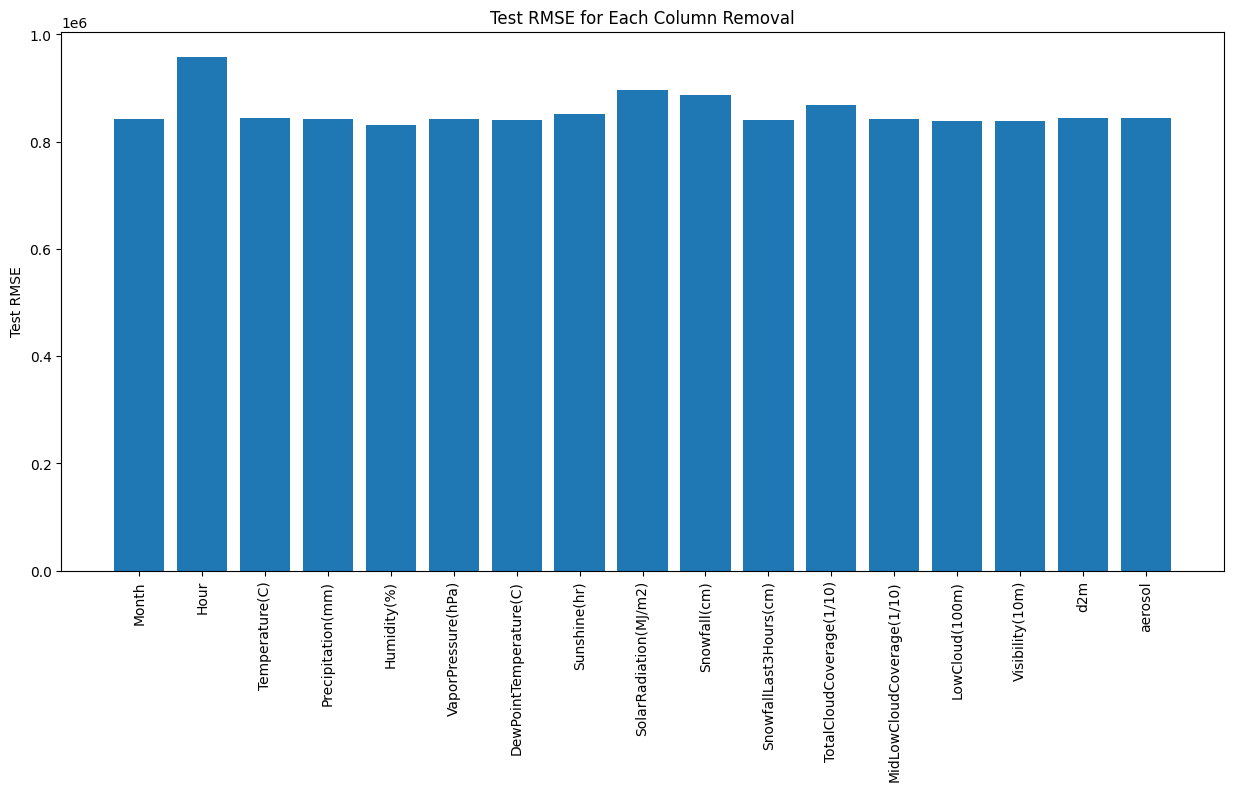

In [34]:
plt.figure(figsize=(15, 7))
plt.bar(rmse_results.keys(), rmse_results.values())
plt.xticks(rotation=90)
plt.ylabel('Test RMSE')
plt.title('Test RMSE for Each Column Removal')
plt.axhline(y=846400, color='r', linestyle='--', label="Reference RMSE: 931521.0182")
plt.legend()
plt.ylim(800900, 1000000)  # Adjust the y-axis limits to zoom in on the data
plt.show()

In [ ]:
# 여러 정규화 방법으로 뺑뺑이